In [1]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torchvision.models as models
from libauc.optimizers import SGD, Adam,PESG
from libauc.losses import CrossEntropyLoss, AUCMLoss
from libauc.sampler import DualSampler
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import os
os.environ['medmnist_data_dir'] = 'D:\\Download\\CSCE633\\project\\data'
import medmnist
from medmnist.dataset import ChestMNIST
# BreastMNIST, PneumoniaMNIST, ChestMNIST, NoduleMNIST3D, AdrenalMNIST3D, VesselMNIST3D, SynapseMNIST3D
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
from medmnist import INFO, Evaluator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

d:\adahx\anaconda3\envs\new_env_project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


parameters

In [2]:
data_flag = 'chestmnist'

NUM_EPOCHS = 200
BATCH_SIZE = 64
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

preprosessing

In [3]:
# data augmentation
data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [4]:
data_dir = 'D:\\Download\\CSCE633\\project\\data'

In [7]:
# load data
train_data = DataClass(root=data_dir, split = 'train', transform=data_transform)
test_data = DataClass(root=data_dir, split = 'test', transform=data_transform)
val_data = DataClass(root=data_dir, split = 'val', transform=data_transform)


In [6]:
# from collections import Counter

# # Convert one-hot encoded labels to class indices
# labels_list = [np.argmax(train_data[i][1]) for i in range(len(train_data))]
# label_counts = Counter(labels_list)

# # Sort the labels before displaying their counts
# sorted_labels = sorted(label_counts.keys())

# for label in sorted_labels:
#     count = label_counts[label]
#     print(f'{label}: {count}')
# total_count = sum(label_counts.values())
# print(f'Total count of all classes: {total_count}')


In [7]:
# label_counts = {
#     0: 50401, 1: 1686, 2: 6445, 3: 9483, 4: 2313,
#     5: 2292, 6: 307, 7: 1935, 8: 1060, 9: 503,
#     10: 676, 11: 535, 12: 761, 13: 71
# }

# total_samples = sum(label_counts.values())

# # Calculate class weights
# class_weights = [total_samples / label_counts[i] for i in range(len(label_counts))]

# # Convert class weights to a tensor
# class_weights_tensor = torch.FloatTensor(class_weights)

In [8]:
# dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=2*BATCH_SIZE, shuffle=False)

In [9]:
print(train_data)
print('=====================')
print(test_data)

Dataset ChestMNIST (chestmnist)
    Number of datapoints: 78468
    Root location: D:\Download\CSCE633\project\data
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST (chestmnist)
    Number of datapoints: 22433
    Root loca

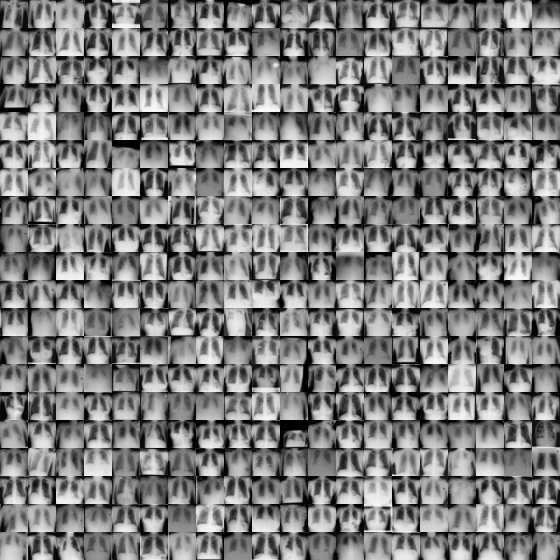

In [10]:
train_data.montage()

# DAM

In [11]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    total = 0
    auc_scores = np.zeros(n_classes)
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            targets = torch.argmax(targets, dim=1)
            
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            targets = targets.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            for i in range(n_classes):
                if len(np.unique(targets == i)) > 1:
                    auc_scores[i] += roc_auc_score(targets == i, outputs[:, i])

    acc = correct / total
    avg_auc_score = np.mean(auc_scores / len(dataloader))

    return avg_auc_score, acc


In [12]:
# # Define the model
# model = models.resnet18(pretrained=False, num_classes=n_classes)
# model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [15]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

## Resnet18

In [19]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Training with Adam optimizer...


100%|██████████| 1227/1227 [00:53<00:00, 22.92it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.3551696144788182, Train ACC: 0.5802620176377632
Test AUC: 0.4400812956737902, Test ACC: 0.5747336513172558
==> Best test AUC and ACC score updated: 0.4401, 0.5747


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.3659622452824995, Train ACC: 0.6256690625477902
Test AUC: 0.45582230663647966, Test ACC: 0.62122765568582
==> Best test AUC and ACC score updated: 0.4558, 0.6212


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.37851644807064727, Train ACC: 0.6420961411021053
Test AUC: 0.4662893256199219, Test ACC: 0.6391922614006151
==> Best test AUC and ACC score updated: 0.4663, 0.6392


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.37215831275932787, Train ACC: 0.642312789927104
Test AUC: 0.4603294378664176, Test ACC: 0.6395934560691838


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.3712127168831607, Train ACC: 0.6314421165315798
Test AUC: 0.45948607904898814, Test ACC: 0.6297418980965542


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.38550956227067534, Train ACC: 0.6404011826477035
Test AUC: 0.4748578054104767, Test ACC: 0.6369634021307895
==> Best test AUC and ACC score updated: 0.4749, 0.6370


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.39396217029279196, Train ACC: 0.6418157720344599
Test AUC: 0.48055259857685423, Test ACC: 0.6394151473275977
==> Best test AUC and ACC score updated: 0.4806, 0.6394


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.39281281573570015, Train ACC: 0.6309578426874649
Test AUC: 0.4812303856901733, Test ACC: 0.629296126242589
==> Best test AUC and ACC score updated: 0.4812, 0.6293


100%|██████████| 1227/1227 [00:49<00:00, 24.74it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.3930327309470009, Train ACC: 0.6406050874241729
Test AUC: 0.48354879708887033, Test ACC: 0.6391476842152186
==> Best test AUC and ACC score updated: 0.4835, 0.6391


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.40788754678122047, Train ACC: 0.6413187541418157
Test AUC: 0.49707392432771924, Test ACC: 0.6373645967993581
==> Best test AUC and ACC score updated: 0.4971, 0.6374


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.39106343139587363, Train ACC: 0.6005123107508793
Test AUC: 0.47825448393588693, Test ACC: 0.6012124994427852


100%|██████████| 1227/1227 [00:50<00:00, 24.21it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.4093356948852849, Train ACC: 0.6403374624050568
Test AUC: 0.5020018711030375, Test ACC: 0.6352248919003254
==> Best test AUC and ACC score updated: 0.5020, 0.6352


100%|██████████| 1227/1227 [00:50<00:00, 24.40it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.40810301969498924, Train ACC: 0.6420324208594587
Test AUC: 0.5071260615428589, Test ACC: 0.6396380332545804
==> Best test AUC and ACC score updated: 0.5071, 0.6396


100%|██████████| 1227/1227 [00:50<00:00, 24.43it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.41383756244743275, Train ACC: 0.6420069327624
Test AUC: 0.5054098856796426, Test ACC: 0.6393705701422012


100%|██████████| 1227/1227 [00:50<00:00, 24.46it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.4218424384760452, Train ACC: 0.6413442422388744
Test AUC: 0.5177906917335212, Test ACC: 0.6374537511701511
==> Best test AUC and ACC score updated: 0.5178, 0.6375


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.419819869374496, Train ACC: 0.6423765101697507
Test AUC: 0.5197358754173617, Test ACC: 0.6395934560691838
==> Best test AUC and ACC score updated: 0.5197, 0.6396


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.42205287061211977, Train ACC: 0.642427486363868
Test AUC: 0.5199940395919185, Test ACC: 0.6391031070298221
==> Best test AUC and ACC score updated: 0.5200, 0.6391


100%|██████████| 1227/1227 [00:49<00:00, 24.63it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.42641788076887904, Train ACC: 0.6407325279094663
Test AUC: 0.5236220855860975, Test ACC: 0.6366513618330139
==> Best test AUC and ACC score updated: 0.5236, 0.6367


100%|██████████| 1227/1227 [00:50<00:00, 24.47it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.43130033507884663, Train ACC: 0.64219809349034
Test AUC: 0.5270741019916027, Test ACC: 0.6374537511701511
==> Best test AUC and ACC score updated: 0.5271, 0.6375


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.4270742362511791, Train ACC: 0.642083397053576
Test AUC: 0.5245858363814152, Test ACC: 0.6383898720634779


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.4280234015874376, Train ACC: 0.6423765101697507
Test AUC: 0.5252368748736875, Test ACC: 0.6397271876253733


100%|██████████| 1227/1227 [00:50<00:00, 24.49it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.433118206220444, Train ACC: 0.642312789927104
Test AUC: 0.5303641325336852, Test ACC: 0.6390585298444256
==> Best test AUC and ACC score updated: 0.5304, 0.6391


100%|██████████| 1227/1227 [00:50<00:00, 24.42it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.4313695799212125, Train ACC: 0.6420069327624
Test AUC: 0.5293837342611827, Test ACC: 0.6398163419961663


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.42675253048414075, Train ACC: 0.6425294387521028
Test AUC: 0.5258245977951169, Test ACC: 0.6395488788837873


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.43447775318744586, Train ACC: 0.6419432125197533
Test AUC: 0.5336961512010828, Test ACC: 0.6366513618330139
==> Best test AUC and ACC score updated: 0.5337, 0.6367


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.4335582070216049, Train ACC: 0.6426059030432788
Test AUC: 0.5311580227440398, Test ACC: 0.6396826104399769


100%|██████████| 1227/1227 [00:51<00:00, 24.03it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.4406603454293584, Train ACC: 0.6421471172962226
Test AUC: 0.5379151714036513, Test ACC: 0.6363838987206348
==> Best test AUC and ACC score updated: 0.5379, 0.6364


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.43564210295666256, Train ACC: 0.6424912066065147
Test AUC: 0.5308321774592396, Test ACC: 0.640217536664735


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.4393102739206213, Train ACC: 0.6431666411785696
Test AUC: 0.5369530528104092, Test ACC: 0.6377212142825301


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.44273505378285266, Train ACC: 0.6428225518682775
Test AUC: 0.5383175033110581, Test ACC: 0.6398609191815628
==> Best test AUC and ACC score updated: 0.5383, 0.6399


100%|██████████| 1227/1227 [00:50<00:00, 24.48it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.4385649555669411, Train ACC: 0.6417520517918133
Test AUC: 0.5357299358307571, Test ACC: 0.635536932198101


100%|██████████| 1227/1227 [00:49<00:00, 24.57it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.43961089420230914, Train ACC: 0.6415481470153438
Test AUC: 0.537142130755273, Test ACC: 0.6362055899790487


100%|██████████| 1227/1227 [00:49<00:00, 24.57it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.43890300510799884, Train ACC: 0.6428480399653362
Test AUC: 0.5341589870721216, Test ACC: 0.6393259929568047


100%|██████████| 1227/1227 [00:49<00:00, 24.56it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.4398010874303254, Train ACC: 0.6424529744609268
Test AUC: 0.5405188270701429, Test ACC: 0.6395043016983908
==> Best test AUC and ACC score updated: 0.5405, 0.6395


100%|██████████| 1227/1227 [00:51<00:00, 23.90it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.44110713441371335, Train ACC: 0.6427078554315134
Test AUC: 0.540931100403533, Test ACC: 0.6403512682209246
==> Best test AUC and ACC score updated: 0.5409, 0.6404


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.43981324997355653, Train ACC: 0.6429117602079829
Test AUC: 0.5393418859586082, Test ACC: 0.640128382293942


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.4435857642633899, Train ACC: 0.6416500994035785
Test AUC: 0.5403452806993647, Test ACC: 0.6374983283555476


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.4432380029114659, Train ACC: 0.6431284090329816
Test AUC: 0.5420528148642773, Test ACC: 0.6386127579904605
==> Best test AUC and ACC score updated: 0.5421, 0.6386


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.4429825690989085, Train ACC: 0.6427205994800428
Test AUC: 0.5428348217662844, Test ACC: 0.6380332545803058
==> Best test AUC and ACC score updated: 0.5428, 0.6380


100%|██████████| 1227/1227 [00:49<00:00, 24.56it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.4426274623785377, Train ACC: 0.6438420757506245
Test AUC: 0.5404140096440015, Test ACC: 0.638568180805064


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.44197693259077797, Train ACC: 0.6422108375388693
Test AUC: 0.5419871385681526, Test ACC: 0.6399054963669594


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.4427865672450517, Train ACC: 0.643332313809451
Test AUC: 0.5440920058715323, Test ACC: 0.6365176302768243
==> Best test AUC and ACC score updated: 0.5441, 0.6365


100%|██████████| 1227/1227 [00:51<00:00, 23.93it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.44486068228434006, Train ACC: 0.6432685935668043
Test AUC: 0.5402667268928584, Test ACC: 0.6395934560691838


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.4491428432530003, Train ACC: 0.6431666411785696
Test AUC: 0.5469286518562961, Test ACC: 0.6390139526590292
==> Best test AUC and ACC score updated: 0.5469, 0.6390


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.44803573642922173, Train ACC: 0.6442881174491513
Test AUC: 0.5442317674154195, Test ACC: 0.6399054963669594


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.44888039778062233, Train ACC: 0.6427588316256309
Test AUC: 0.5432658871491027, Test ACC: 0.6379441002095128


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.4493166928473155, Train ACC: 0.6432431054697456
Test AUC: 0.5438095769753089, Test ACC: 0.6392368385860117


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.4486027988254304, Train ACC: 0.6433195697609216
Test AUC: 0.545448610007311, Test ACC: 0.6398163419961663


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.4452927636901728, Train ACC: 0.6437656114594484
Test AUC: 0.5445499944477372, Test ACC: 0.6397717648107698


100%|██████████| 1227/1227 [00:50<00:00, 24.47it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.4415863737316172, Train ACC: 0.6432176173726869
Test AUC: 0.5374231934214089, Test ACC: 0.6398163419961663


100%|██████████| 1227/1227 [00:50<00:00, 24.07it/s]


==> Evaluating after epoch 51 ...
Train AUC: 0.44792028149655483, Train ACC: 0.6439950043329765
Test AUC: 0.5453645900521134, Test ACC: 0.6400392279231489


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 52 ...
Train AUC: 0.4501195976160348, Train ACC: 0.6445557424682673
Test AUC: 0.5463901976429858, Test ACC: 0.6379886773949093


100%|██████████| 1227/1227 [00:49<00:00, 24.63it/s]


==> Evaluating after epoch 53 ...
Train AUC: 0.4499327092633275, Train ACC: 0.6437910995565072
Test AUC: 0.5470421082499369, Test ACC: 0.6350020059733429
==> Best test AUC and ACC score updated: 0.5470, 0.6350


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 54 ...
Train AUC: 0.44466381002775063, Train ACC: 0.6442243972065046
Test AUC: 0.5420950864037138, Test ACC: 0.6399500735523559


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 55 ...
Train AUC: 0.44914149199532527, Train ACC: 0.6440969567212111
Test AUC: 0.544858386567375, Test ACC: 0.6380332545803058


100%|██████████| 1227/1227 [00:49<00:00, 24.63it/s]


==> Evaluating after epoch 56 ...
Train AUC: 0.4467992653800423, Train ACC: 0.6431284090329816
Test AUC: 0.5452171338553076, Test ACC: 0.6392814157714082


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 57 ...
Train AUC: 0.4444970743674009, Train ACC: 0.6421726053932814
Test AUC: 0.5395938478422051, Test ACC: 0.6345116569339811


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 58 ...
Train AUC: 0.44998132599898516, Train ACC: 0.6434979864403324
Test AUC: 0.5438320110393489, Test ACC: 0.6394151473275977


100%|██████████| 1227/1227 [00:51<00:00, 23.98it/s]


==> Evaluating after epoch 59 ...
Train AUC: 0.44860339868494054, Train ACC: 0.6443136055462099
Test AUC: 0.5469391803901873, Test ACC: 0.6393705701422012


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 60 ...
Train AUC: 0.4501964495903293, Train ACC: 0.6424657185094561
Test AUC: 0.5423161649592371, Test ACC: 0.635536932198101


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 61 ...
Train AUC: 0.4492697958144847, Train ACC: 0.64219809349034
Test AUC: 0.5485047752974878, Test ACC: 0.6327731467035171
==> Best test AUC and ACC score updated: 0.5485, 0.6328


100%|██████████| 1227/1227 [00:49<00:00, 24.74it/s]


==> Evaluating after epoch 62 ...
Train AUC: 0.4508271953777005, Train ACC: 0.6439695162359178
Test AUC: 0.5447363258307006, Test ACC: 0.6397717648107698


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 63 ...
Train AUC: 0.44598616580262956, Train ACC: 0.6432685935668043
Test AUC: 0.5392314811224949, Test ACC: 0.6397717648107698


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 64 ...
Train AUC: 0.45169728152108013, Train ACC: 0.6450272722638528
Test AUC: 0.549023917831749, Test ACC: 0.6391476842152186
==> Best test AUC and ACC score updated: 0.5490, 0.6391


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 65 ...
Train AUC: 0.4525562597015565, Train ACC: 0.644237141255034
Test AUC: 0.5459984310922905, Test ACC: 0.6383452948780814


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 66 ...
Train AUC: 0.4533328395975076, Train ACC: 0.6436254269256257
Test AUC: 0.5501453352889453, Test ACC: 0.6389247982882361
==> Best test AUC and ACC score updated: 0.5501, 0.6389


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 67 ...
Train AUC: 0.45053096392098163, Train ACC: 0.6445939746138554
Test AUC: 0.5436529150586223, Test ACC: 0.6375874827263407


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 68 ...
Train AUC: 0.44915125857862614, Train ACC: 0.6437146352653311
Test AUC: 0.549199196895649, Test ACC: 0.6397271876253733


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 69 ...
Train AUC: 0.45200183728148885, Train ACC: 0.6452694091859101
Test AUC: 0.5469784304097018, Test ACC: 0.6390139526590292


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 70 ...
Train AUC: 0.45104361739716864, Train ACC: 0.644428301982974
Test AUC: 0.546083936643814, Test ACC: 0.6399054963669594


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 71 ...
Train AUC: 0.45342574543838643, Train ACC: 0.6437146352653311
Test AUC: 0.5492477419628019, Test ACC: 0.640217536664735


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 72 ...
Train AUC: 0.45178377055972685, Train ACC: 0.64469592700209
Test AUC: 0.5475393187202611, Test ACC: 0.6399054963669594


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 73 ...
Train AUC: 0.45151392131216816, Train ACC: 0.6442881174491513
Test AUC: 0.5499614668607695, Test ACC: 0.6382115633218919


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 74 ...
Train AUC: 0.45061804559965124, Train ACC: 0.6433832900035683
Test AUC: 0.545506753438782, Test ACC: 0.638657335175857


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 75 ...
Train AUC: 0.4534658106556332, Train ACC: 0.6447851353417954
Test AUC: 0.5494185740929006, Test ACC: 0.6391476842152186


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 76 ...
Train AUC: 0.45501630535816107, Train ACC: 0.6438930519447418
Test AUC: 0.5458990469094254, Test ACC: 0.6380778317657023


100%|██████████| 1227/1227 [00:49<00:00, 24.57it/s]


==> Evaluating after epoch 77 ...
Train AUC: 0.4571744840523965, Train ACC: 0.6440459805270938
Test AUC: 0.5508875486474922, Test ACC: 0.6346899656755672
==> Best test AUC and ACC score updated: 0.5509, 0.6347


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 78 ...
Train AUC: 0.4536471164228487, Train ACC: 0.6446831829535606
Test AUC: 0.5453097870636999, Test ACC: 0.638568180805064


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 79 ...
Train AUC: 0.45580861064880956, Train ACC: 0.6442881174491513
Test AUC: 0.5480324127861168, Test ACC: 0.6390139526590292


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 80 ...
Train AUC: 0.45545138715949773, Train ACC: 0.6445557424682673
Test AUC: 0.5481198708849812, Test ACC: 0.6368296705745999


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 81 ...
Train AUC: 0.45426960801120764, Train ACC: 0.6437528674109191
Test AUC: 0.5451004151464003, Test ACC: 0.6364284759060312


100%|██████████| 1227/1227 [00:51<00:00, 23.84it/s]


==> Evaluating after epoch 82 ...
Train AUC: 0.4545573588466943, Train ACC: 0.6447978793903247
Test AUC: 0.5451489353478663, Test ACC: 0.6392814157714082


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 83 ...
Train AUC: 0.45390323581242514, Train ACC: 0.6450017841667941
Test AUC: 0.5462266039298733, Test ACC: 0.6378995230241162


100%|██████████| 1227/1227 [00:49<00:00, 24.85it/s]


==> Evaluating after epoch 84 ...
Train AUC: 0.45549175501345485, Train ACC: 0.644542998419738
Test AUC: 0.5497327091545563, Test ACC: 0.6387019123612535


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 85 ...
Train AUC: 0.45420730880860544, Train ACC: 0.6448998317785594
Test AUC: 0.5513490051939683, Test ACC: 0.6366067846476173
==> Best test AUC and ACC score updated: 0.5513, 0.6366


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 86 ...
Train AUC: 0.4536196721084846, Train ACC: 0.6454223377682622
Test AUC: 0.5518011755356617, Test ACC: 0.6385236036196674
==> Best test AUC and ACC score updated: 0.5518, 0.6385


100%|██████████| 1227/1227 [00:49<00:00, 24.78it/s]


==> Evaluating after epoch 87 ...
Train AUC: 0.45262562234844206, Train ACC: 0.6441989091094459
Test AUC: 0.5487390604332074, Test ACC: 0.6391476842152186


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 88 ...
Train AUC: 0.4531477202270679, Train ACC: 0.6436764031197431
Test AUC: 0.549036519289853, Test ACC: 0.6381669861364954


100%|██████████| 1227/1227 [00:49<00:00, 24.77it/s]


==> Evaluating after epoch 89 ...
Train AUC: 0.45272496978913507, Train ACC: 0.6446067186623846
Test AUC: 0.547406890891964, Test ACC: 0.638568180805064


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 90 ...
Train AUC: 0.45415364588053425, Train ACC: 0.6449635520212061
Test AUC: 0.5474614692127097, Test ACC: 0.636918824945393


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 91 ...
Train AUC: 0.45374822460085423, Train ACC: 0.6440842126726819
Test AUC: 0.5488858292599555, Test ACC: 0.6397271876253733


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 92 ...
Train AUC: 0.4503189858111266, Train ACC: 0.6435362185859204
Test AUC: 0.5434431849256705, Test ACC: 0.6385236036196674


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 93 ...
Train AUC: 0.45593805597285525, Train ACC: 0.6447596472447367
Test AUC: 0.5485843982122215, Test ACC: 0.638568180805064


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 94 ...
Train AUC: 0.4547029001768893, Train ACC: 0.6447978793903247
Test AUC: 0.5525763816471858, Test ACC: 0.6387910667320466
==> Best test AUC and ACC score updated: 0.5526, 0.6388


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 95 ...
Train AUC: 0.45566529477916384, Train ACC: 0.644581230565326
Test AUC: 0.549712485646889, Test ACC: 0.6391922614006151


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 96 ...
Train AUC: 0.45556594266129885, Train ACC: 0.6442116531579752
Test AUC: 0.5495680136454669, Test ACC: 0.638657335175857


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 97 ...
Train AUC: 0.45298539523712783, Train ACC: 0.6435489626344497
Test AUC: 0.5486567857378418, Test ACC: 0.6344670797485846


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 98 ...
Train AUC: 0.4560423719578336, Train ACC: 0.6446704389050314
Test AUC: 0.5514751392497536, Test ACC: 0.6396826104399769


100%|██████████| 1227/1227 [00:49<00:00, 24.63it/s]


==> Evaluating after epoch 99 ...
Train AUC: 0.4559172407066088, Train ACC: 0.6453841056226742
Test AUC: 0.5488033229015562, Test ACC: 0.6409753488164758


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 100 ...
Train AUC: 0.4534767940327096, Train ACC: 0.644237141255034
Test AUC: 0.5486865862108176, Test ACC: 0.6383007176926849


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 101 ...
Train AUC: 0.45085556849713676, Train ACC: 0.6440077483815059
Test AUC: 0.5446291828064311, Test ACC: 0.640128382293942


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 102 ...
Train AUC: 0.45607726021688555, Train ACC: 0.6441097007697405
Test AUC: 0.5496980177361952, Test ACC: 0.6397717648107698


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 103 ...
Train AUC: 0.45504496913106224, Train ACC: 0.6440969567212111
Test AUC: 0.550422184031923, Test ACC: 0.6402621138501315


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 104 ...
Train AUC: 0.4569115562040721, Train ACC: 0.6443136055462099
Test AUC: 0.5500654581453808, Test ACC: 0.6391031070298221


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 105 ...
Train AUC: 0.45624370672658504, Train ACC: 0.644237141255034
Test AUC: 0.553205125187668, Test ACC: 0.6390585298444256
==> Best test AUC and ACC score updated: 0.5532, 0.6391


100%|██████████| 1227/1227 [00:49<00:00, 24.76it/s]


==> Evaluating after epoch 106 ...
Train AUC: 0.457415375920878, Train ACC: 0.645830147321201
Test AUC: 0.5515334886513709, Test ACC: 0.6385236036196674


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 107 ...
Train AUC: 0.45503170297058154, Train ACC: 0.644619462710914
Test AUC: 0.5521847955744698, Test ACC: 0.6379441002095128


100%|██████████| 1227/1227 [00:49<00:00, 24.74it/s]


==> Evaluating after epoch 108 ...
Train AUC: 0.45508414449556617, Train ACC: 0.6444537900800327
Test AUC: 0.5482715717782232, Test ACC: 0.6368742477599965


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 109 ...
Train AUC: 0.45286078800651264, Train ACC: 0.6450655044094408
Test AUC: 0.5519502908557967, Test ACC: 0.6382561405072884


100%|██████████| 1227/1227 [00:49<00:00, 24.74it/s]


==> Evaluating after epoch 110 ...
Train AUC: 0.4560241216265432, Train ACC: 0.6442753734006219
Test AUC: 0.5465700631265775, Test ACC: 0.6391922614006151


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 111 ...
Train AUC: 0.453143312628883, Train ACC: 0.6444155579344446
Test AUC: 0.5487011251158024, Test ACC: 0.6391031070298221


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 112 ...
Train AUC: 0.4581258782272507, Train ACC: 0.6432176173726869
Test AUC: 0.5493248790887005, Test ACC: 0.6363838987206348


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 113 ...
Train AUC: 0.4567930520975606, Train ACC: 0.6438803078962124
Test AUC: 0.5512032417833045, Test ACC: 0.6378549458387197


100%|██████████| 1227/1227 [00:49<00:00, 24.63it/s]


==> Evaluating after epoch 114 ...
Train AUC: 0.4583066594660337, Train ACC: 0.6450909925064995
Test AUC: 0.5498059911396549, Test ACC: 0.6389693754736326


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 115 ...
Train AUC: 0.454130122107083, Train ACC: 0.6440204924300351
Test AUC: 0.5449686835774568, Test ACC: 0.6399500735523559


100%|██████████| 1227/1227 [00:51<00:00, 24.03it/s]


==> Evaluating after epoch 116 ...
Train AUC: 0.4566359054391425, Train ACC: 0.6446831829535606
Test AUC: 0.5500229270383182, Test ACC: 0.6396826104399769


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 117 ...
Train AUC: 0.4584534177720223, Train ACC: 0.642083397053576
Test AUC: 0.552586893940524, Test ACC: 0.6324165292203451


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 118 ...
Train AUC: 0.45375899459851815, Train ACC: 0.6445557424682673
Test AUC: 0.5480554398420999, Test ACC: 0.6392814157714082


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 119 ...
Train AUC: 0.45351768753200616, Train ACC: 0.6420069327624
Test AUC: 0.5503638091264401, Test ACC: 0.6352248919003254


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 120 ...
Train AUC: 0.45472242753432923, Train ACC: 0.6447341591476781
Test AUC: 0.5494419936777277, Test ACC: 0.6352694690857219


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 121 ...
Train AUC: 0.45766256459558463, Train ACC: 0.6450272722638528
Test AUC: 0.5480138511569075, Test ACC: 0.6391922614006151


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 122 ...
Train AUC: 0.45796962311734896, Train ACC: 0.6447086710506194
Test AUC: 0.5506254578845753, Test ACC: 0.6377657914679267


100%|██████████| 1227/1227 [00:49<00:00, 24.74it/s]


==> Evaluating after epoch 123 ...
Train AUC: 0.4541200531835857, Train ACC: 0.6442498853035632
Test AUC: 0.5459158692938237, Test ACC: 0.6389693754736326


100%|██████████| 1227/1227 [00:50<00:00, 24.08it/s]


==> Evaluating after epoch 124 ...
Train AUC: 0.45418333129829375, Train ACC: 0.6434724983432737
Test AUC: 0.5504181024098577, Test ACC: 0.6348236972317568


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 125 ...
Train AUC: 0.45586322169442456, Train ACC: 0.6450527603609114
Test AUC: 0.5487414563684162, Test ACC: 0.6390139526590292


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 126 ...
Train AUC: 0.4560788690999052, Train ACC: 0.6450655044094408
Test AUC: 0.5503511357838106, Test ACC: 0.6412428119288548


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 127 ...
Train AUC: 0.45402641846672437, Train ACC: 0.6444537900800327
Test AUC: 0.548049581216968, Test ACC: 0.6390585298444256


100%|██████████| 1227/1227 [00:49<00:00, 24.60it/s]


==> Evaluating after epoch 128 ...
Train AUC: 0.45518909926138146, Train ACC: 0.6437910995565072
Test AUC: 0.5476675317191659, Test ACC: 0.6378103686533232


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 129 ...
Train AUC: 0.45401202232987575, Train ACC: 0.6449125758270887
Test AUC: 0.5501108504851204, Test ACC: 0.6388802211028396


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 130 ...
Train AUC: 0.4576874237491494, Train ACC: 0.6446704389050314
Test AUC: 0.5489128736325898, Test ACC: 0.6385236036196674


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 131 ...
Train AUC: 0.4584168121309536, Train ACC: 0.6441734210123872
Test AUC: 0.548527922346411, Test ACC: 0.6405741541479071


100%|██████████| 1227/1227 [00:51<00:00, 23.96it/s]


==> Evaluating after epoch 132 ...
Train AUC: 0.4574869337601756, Train ACC: 0.6448233674873833
Test AUC: 0.5514686350928032, Test ACC: 0.6395488788837873


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 133 ...
Train AUC: 0.45692852093102065, Train ACC: 0.6431029209359229
Test AUC: 0.5495000170730049, Test ACC: 0.6325502607765345


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 134 ...
Train AUC: 0.45832545042936035, Train ACC: 0.6450272722638528
Test AUC: 0.5504978537234451, Test ACC: 0.6384790264342709


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 135 ...
Train AUC: 0.45471670333649244, Train ACC: 0.6450017841667941
Test AUC: 0.5509065981660097, Test ACC: 0.6377212142825301


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 136 ...
Train AUC: 0.4568678189723941, Train ACC: 0.6440842126726819
Test AUC: 0.5498251960507953, Test ACC: 0.63874648954665


100%|██████████| 1227/1227 [00:49<00:00, 24.74it/s]


==> Evaluating after epoch 137 ...
Train AUC: 0.4579065306557758, Train ACC: 0.6430519447418056
Test AUC: 0.5489858541989242, Test ACC: 0.6345116569339811


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 138 ...
Train AUC: 0.4586128763373333, Train ACC: 0.6459193556609063
Test AUC: 0.5481392445619201, Test ACC: 0.6385236036196674


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 139 ...
Train AUC: 0.4585579331981281, Train ACC: 0.6450782484579701
Test AUC: 0.5528246159148272, Test ACC: 0.6398609191815628


100%|██████████| 1227/1227 [00:51<00:00, 23.88it/s]


==> Evaluating after epoch 140 ...
Train AUC: 0.45689917732992213, Train ACC: 0.6444920222256206
Test AUC: 0.5466973985779752, Test ACC: 0.6393705701422012


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 141 ...
Train AUC: 0.4583299483428728, Train ACC: 0.645600754447673
Test AUC: 0.5492135243302332, Test ACC: 0.6368742477599965


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 142 ...
Train AUC: 0.4554180332078728, Train ACC: 0.6456262425447317
Test AUC: 0.5483763136294005, Test ACC: 0.6384790264342709


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 143 ...
Train AUC: 0.4533937662320327, Train ACC: 0.6432431054697456
Test AUC: 0.5465749304870741, Test ACC: 0.6342441938216021


100%|██████████| 1227/1227 [00:49<00:00, 24.63it/s]


==> Evaluating after epoch 144 ...
Train AUC: 0.45710283668276336, Train ACC: 0.6451292246520874
Test AUC: 0.5505912279704412, Test ACC: 0.6386127579904605


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 145 ...
Train AUC: 0.4585901766408346, Train ACC: 0.6407452719579956
Test AUC: 0.5493316351087364, Test ACC: 0.6314358311416217


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 146 ...
Train AUC: 0.4555600127746132, Train ACC: 0.6444155579344446
Test AUC: 0.5478360113625598, Test ACC: 0.6381224089510988


100%|██████████| 1227/1227 [00:50<00:00, 24.10it/s]


==> Evaluating after epoch 147 ...
Train AUC: 0.4506934872502093, Train ACC: 0.6443645817403273
Test AUC: 0.5460801150294445, Test ACC: 0.6395043016983908


100%|██████████| 1227/1227 [00:50<00:00, 24.10it/s]


==> Evaluating after epoch 148 ...
Train AUC: 0.45599376883432574, Train ACC: 0.6443136055462099
Test AUC: 0.5502208269711985, Test ACC: 0.6382561405072884


100%|██████████| 1227/1227 [00:49<00:00, 24.77it/s]


==> Evaluating after epoch 149 ...
Train AUC: 0.4582189468582088, Train ACC: 0.6457281949329663
Test AUC: 0.554052364796927, Test ACC: 0.6372308652431685
==> Best test AUC and ACC score updated: 0.5541, 0.6372


100%|██████████| 1227/1227 [00:49<00:00, 24.59it/s]


==> Evaluating after epoch 150 ...
Train AUC: 0.45505730859800675, Train ACC: 0.64469592700209
Test AUC: 0.5468017394907847, Test ACC: 0.6390585298444256


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 151 ...
Train AUC: 0.45884322796598964, Train ACC: 0.6450272722638528
Test AUC: 0.5513498399935058, Test ACC: 0.6389247982882361


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 152 ...
Train AUC: 0.4576687152347804, Train ACC: 0.6449253198756181
Test AUC: 0.5483597669329263, Test ACC: 0.6391476842152186


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 153 ...
Train AUC: 0.4575969888611531, Train ACC: 0.6447596472447367
Test AUC: 0.5474235303619787, Test ACC: 0.6375874827263407


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 154 ...
Train AUC: 0.4590465826732782, Train ACC: 0.645753683030025
Test AUC: 0.5525752522444766, Test ACC: 0.6390139526590292


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 155 ...
Train AUC: 0.46054409859180157, Train ACC: 0.6447214150991487
Test AUC: 0.5502091488192041, Test ACC: 0.6362055899790487


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 156 ...
Train AUC: 0.45890699885650144, Train ACC: 0.6449508079726768
Test AUC: 0.5476161323877079, Test ACC: 0.6365622074622208


100%|██████████| 1227/1227 [00:49<00:00, 24.76it/s]


==> Evaluating after epoch 157 ...
Train AUC: 0.45650210730370444, Train ACC: 0.6444410460315033
Test AUC: 0.5511202750181792, Test ACC: 0.6384790264342709


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 158 ...
Train AUC: 0.4556814473439729, Train ACC: 0.6366416883315492
Test AUC: 0.549366634604641, Test ACC: 0.6242143271073864


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 159 ...
Train AUC: 0.4575762717267336, Train ACC: 0.6455370342050263
Test AUC: 0.5495682931469539, Test ACC: 0.6384344492488744


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 160 ...
Train AUC: 0.4461889946188717, Train ACC: 0.6392032420859458
Test AUC: 0.5377289010324345, Test ACC: 0.62902866313021


100%|██████████| 1227/1227 [00:50<00:00, 24.54it/s]


==> Evaluating after epoch 161 ...
Train AUC: 0.45391581651354435, Train ACC: 0.6452056889432635
Test AUC: 0.5474430449551498, Test ACC: 0.6392368385860117


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 162 ...
Train AUC: 0.4591320400725509, Train ACC: 0.6449125758270887
Test AUC: 0.5503851071171703, Test ACC: 0.6363838987206348


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 163 ...
Train AUC: 0.45438525346467207, Train ACC: 0.6450272722638528
Test AUC: 0.5455004754934338, Test ACC: 0.6380778317657023


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 164 ...
Train AUC: 0.45828020048033186, Train ACC: 0.6455497782535556
Test AUC: 0.5449499509018791, Test ACC: 0.6382115633218919


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 165 ...
Train AUC: 0.4579619018285947, Train ACC: 0.6453203853800276
Test AUC: 0.5447515576765897, Test ACC: 0.6384344492488744


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 166 ...
Train AUC: 0.45467455319446487, Train ACC: 0.6450272722638528
Test AUC: 0.5483194526639898, Test ACC: 0.6387910667320466


100%|██████████| 1227/1227 [00:49<00:00, 24.70it/s]


==> Evaluating after epoch 167 ...
Train AUC: 0.45478929053609185, Train ACC: 0.6441351888667992
Test AUC: 0.545623803171787, Test ACC: 0.6399946507377524


100%|██████████| 1227/1227 [00:49<00:00, 24.76it/s]


==> Evaluating after epoch 168 ...
Train AUC: 0.4556181402837726, Train ACC: 0.6447341591476781
Test AUC: 0.5499572944804114, Test ACC: 0.6389247982882361


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 169 ...
Train AUC: 0.45126168968147334, Train ACC: 0.6432940816638629
Test AUC: 0.5462949360564254, Test ACC: 0.6349574287879464


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 170 ...
Train AUC: 0.45699677524235555, Train ACC: 0.6458046592241423
Test AUC: 0.5495793406747934, Test ACC: 0.6374537511701511


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 171 ...
Train AUC: 0.45975990911157644, Train ACC: 0.6452694091859101
Test AUC: 0.5510143904996668, Test ACC: 0.6384790264342709


100%|██████████| 1227/1227 [00:49<00:00, 24.74it/s]


==> Evaluating after epoch 172 ...
Train AUC: 0.4580839821401061, Train ACC: 0.6434979864403324
Test AUC: 0.5456398952296941, Test ACC: 0.6377212142825301


100%|██████████| 1227/1227 [00:49<00:00, 24.73it/s]


==> Evaluating after epoch 173 ...
Train AUC: 0.4570459240414503, Train ACC: 0.6452439210888515
Test AUC: 0.5475308503758514, Test ACC: 0.6390139526590292


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 174 ...
Train AUC: 0.4583306301330373, Train ACC: 0.6436509150226845
Test AUC: 0.5513691357055632, Test ACC: 0.6392368385860117


100%|██████████| 1227/1227 [00:49<00:00, 24.75it/s]


==> Evaluating after epoch 175 ...
Train AUC: 0.45861549882477, Train ACC: 0.6417520517918133
Test AUC: 0.5508484845503467, Test ACC: 0.6325948379619311


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 176 ...
Train AUC: 0.4575108890556723, Train ACC: 0.6454350818167915
Test AUC: 0.549105572597919, Test ACC: 0.6400838051085455


100%|██████████| 1227/1227 [00:49<00:00, 24.63it/s]


==> Evaluating after epoch 177 ...
Train AUC: 0.4558299760521333, Train ACC: 0.644581230565326
Test AUC: 0.5461971540513232, Test ACC: 0.6363838987206348


100%|██████████| 1227/1227 [00:49<00:00, 24.72it/s]


==> Evaluating after epoch 178 ...
Train AUC: 0.453975554185063, Train ACC: 0.6439695162359178
Test AUC: 0.5477795973244308, Test ACC: 0.6378549458387197


100%|██████████| 1227/1227 [00:51<00:00, 24.05it/s]


==> Evaluating after epoch 179 ...
Train AUC: 0.45515406794191293, Train ACC: 0.6443263495947392
Test AUC: 0.5484023460455464, Test ACC: 0.6365176302768243


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 180 ...
Train AUC: 0.4566361155109214, Train ACC: 0.6454095937197328
Test AUC: 0.5496406464319995, Test ACC: 0.6389693754736326


100%|██████████| 1227/1227 [00:49<00:00, 24.68it/s]


==> Evaluating after epoch 181 ...
Train AUC: 0.4595527529208798, Train ACC: 0.6447341591476781
Test AUC: 0.5510552611808212, Test ACC: 0.6349128516025498


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 182 ...
Train AUC: 0.45668857625638076, Train ACC: 0.6454223377682622
Test AUC: 0.5514918106473377, Test ACC: 0.6378103686533232


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 183 ...
Train AUC: 0.457318489409367, Train ACC: 0.6447086710506194
Test AUC: 0.5453190916725721, Test ACC: 0.637275442428565


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 184 ...
Train AUC: 0.45828647630177055, Train ACC: 0.6448743436815008
Test AUC: 0.5494050784957549, Test ACC: 0.6398163419961663


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 185 ...
Train AUC: 0.45763891864594713, Train ACC: 0.6448106234388541
Test AUC: 0.550608516404614, Test ACC: 0.6391476842152186


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 186 ...
Train AUC: 0.460549600490992, Train ACC: 0.6437018912168018
Test AUC: 0.5521806375078874, Test ACC: 0.6342441938216021


100%|██████████| 1227/1227 [00:49<00:00, 24.65it/s]


==> Evaluating after epoch 187 ...
Train AUC: 0.45914672525619765, Train ACC: 0.6452566651373809
Test AUC: 0.5491151844068143, Test ACC: 0.6393705701422012


100%|██████████| 1227/1227 [00:49<00:00, 24.69it/s]


==> Evaluating after epoch 188 ...
Train AUC: 0.45914079441720174, Train ACC: 0.6454223377682622
Test AUC: 0.5552384709179321, Test ACC: 0.6391922614006151
==> Best test AUC and ACC score updated: 0.5552, 0.6392


100%|██████████| 1227/1227 [00:49<00:00, 24.66it/s]


==> Evaluating after epoch 189 ...
Train AUC: 0.45865193728680875, Train ACC: 0.644428301982974
Test AUC: 0.5489630839640685, Test ACC: 0.637097133686979


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 190 ...
Train AUC: 0.45689898537451795, Train ACC: 0.6435744507315084
Test AUC: 0.5499535589251976, Test ACC: 0.6387019123612535


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 191 ...
Train AUC: 0.4601989714109112, Train ACC: 0.6437401233623897
Test AUC: 0.5527755779325719, Test ACC: 0.6349574287879464


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 192 ...
Train AUC: 0.45578929847159694, Train ACC: 0.6453458734770862
Test AUC: 0.5456273977461781, Test ACC: 0.6350911603441358


100%|██████████| 1227/1227 [00:50<00:00, 24.51it/s]


==> Evaluating after epoch 193 ...
Train AUC: 0.45411096971713777, Train ACC: 0.6450017841667941
Test AUC: 0.5490845654028031, Test ACC: 0.6378995230241162


100%|██████████| 1227/1227 [00:49<00:00, 24.64it/s]


==> Evaluating after epoch 194 ...
Train AUC: 0.4599140841861267, Train ACC: 0.6451419687006168
Test AUC: 0.5506820733390889, Test ACC: 0.6378103686533232


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 195 ...
Train AUC: 0.4563093502078428, Train ACC: 0.6445302543712087
Test AUC: 0.5522060357322249, Test ACC: 0.6398163419961663


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 196 ...
Train AUC: 0.46128223522451817, Train ACC: 0.6451929448947341
Test AUC: 0.5527234920783268, Test ACC: 0.6377657914679267


100%|██████████| 1227/1227 [00:49<00:00, 24.71it/s]


==> Evaluating after epoch 197 ...
Train AUC: 0.45932206799486003, Train ACC: 0.6445557424682673
Test AUC: 0.548237766965969, Test ACC: 0.6393705701422012


100%|██████████| 1227/1227 [00:49<00:00, 24.67it/s]


==> Evaluating after epoch 198 ...
Train AUC: 0.45175700722278966, Train ACC: 0.6441351888667992
Test AUC: 0.5485453854346535, Test ACC: 0.6388356439174431


100%|██████████| 1227/1227 [00:49<00:00, 24.61it/s]


==> Evaluating after epoch 199 ...
Train AUC: 0.4579272919530789, Train ACC: 0.6458938675638477
Test AUC: 0.5466599451816238, Test ACC: 0.6378549458387197


100%|██████████| 1227/1227 [00:49<00:00, 24.62it/s]


==> Evaluating after epoch 200 ...
Train AUC: 0.4602382455748651, Train ACC: 0.6452566651373809
Test AUC: 0.5485788942482096, Test ACC: 0.6387019123612535
Best model: Adam, AUC: 0.5552, ACC: 0.6392, epoch: 188


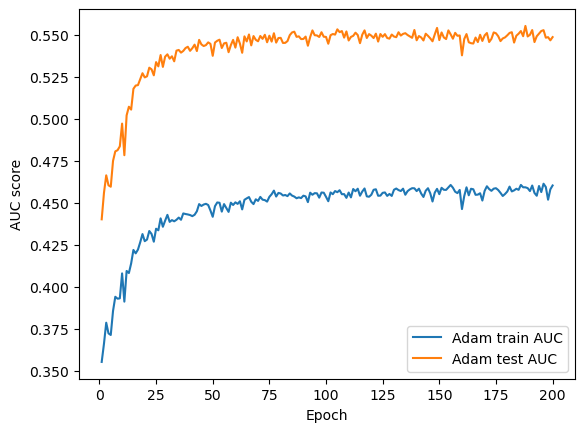

In [20]:
import copy
optimizers = {
    'Adam': Adam(model.parameters(), lr=lr, weight_decay=1e-4),
    # 'SGD': SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
}

best_models = {}
best_aucs = {}

for optimizer_name, optimizer in optimizers.items():
    print(f"Training with {optimizer_name} optimizer...")

    model.train()  # Reset the model to training mode

    best_auc = 0
    best_acc = 0
    best_epoch = 0

    train_auc_scores = []
    test_auc_scores = []
    epochs = []

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        train_loss = 0
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Convert one-hot encoded targets to class labels
            targets = targets.argmax(dim=1)

            # targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        print(f"==> Evaluating after epoch {epoch + 1} ...")
        train_metrics = evaluate(train_loader)
        test_metrics = evaluate(test_loader)
        
        print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
        print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

        # Check if AUC score improved
        if test_metrics[0] > best_auc:
            best_auc = test_metrics[0]
            best_acc = test_metrics[1]
            best_epoch = epoch + 1
            print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
            best_models[optimizer_name] = {
                'state_dict': copy.deepcopy(model.state_dict()),
                'auc': best_auc,
                'acc': best_acc,
                'epoch': best_epoch
            }

        # Append AUC scores and epoch numbers
        train_auc_scores.append(train_metrics[0])
        test_auc_scores.append(test_metrics[0])
        epochs.append(epoch+1)

    best_aucs[optimizer_name] = best_auc

    # Plot the train and test AUC scores vs epoch for each optimizer
    plt.plot(epochs, train_auc_scores, label=f"{optimizer_name} train AUC")
    plt.plot(epochs, test_auc_scores, label=f"{optimizer_name} test AUC")

# Find the optimizer with the best AUC score
best_optimizer = max(best_aucs, key=best_aucs.get)
best_model_info = best_models[best_optimizer]

# Save the best model
torch.save(best_model_info['state_dict'], 'best_pretrained_model_chestmnist.pth')

print(f"Best model: {best_optimizer}, AUC: {best_model_info['auc']:.4f}, ACC: {best_model_info['acc']:.4f}, epoch: {best_model_info['epoch']}")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()

# LibAUC

In [13]:
# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List the files in the current directory
# files = os.listdir(current_directory)
# print("Files in the current directory:")
# for file in files:
#     print(file)

Current working directory: d:\Download\CSCE633\project


## ResNet18 with dropout

In [36]:
# from torchvision.models.resnet import ResNet, BasicBlock
# class ResNet18WithDropout(ResNet):
#     def __init__(self, num_classes=2, dropout_rate=0.7):
#         super(ResNet18WithDropout, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
#         self.dropout_rate = dropout_rate
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change the input channels to 1
#         self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)  # Change the output size to match the pretrained model

# # Instantiate the modified ResNet18 with dropout
# model = ResNet18WithDropout(dropout_rate=0.7)

# # Load the state dictionary from the .pth file
# pretrained_weights = torch.load("best_pretrained_model_chestmnist.pth")

In [40]:
# def fix_state_dict_keys(state_dict):
#     new_state_dict = {}
#     for k, v in state_dict.items():
#         k = k.replace("module.", "")
#         if k.startswith("fc"):
#             continue  # Skip the fully connected layer weights
#         new_state_dict[k] = v
#     return new_state_dict

# fixed_pretrained_weights = fix_state_dict_keys(pretrained_weights)

In [41]:
# Transfer the weights from the pretrained model to the modified model with dropout
# model.load_state_dict(fixed_pretrained_weights, strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [42]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

ResNet18WithDropout(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

In [26]:
# SEED = 123
# BATCH_SIZE = 64
# lr = 0.001 # using smaller learning rate is better
# epoch_decay = 2e-3
# weight_decay = 1e-5
# margin = 1.0

In [27]:
# # define loss & optimizer
# loss_fn = AUCMLoss()
# optimizer = PESG(model, 
#                  loss_fn=loss_fn, 
#                  lr=lr, 
#                  margin=margin, 
#                  epoch_decay=epoch_decay, 
#                  weight_decay=weight_decay)

In [43]:
# SEED = 123
# BATCH_SIZE = 128
# # lr = 0.001 # using smaller learning rate is better
# lr = 0.01
# # epoch_decay = 2e-3
# epoch_decay = 0.003
# weight_decay = 1e-5
# margin = 1.0

In [44]:
# # define loss & optimizer
# loss_fn = AUCMLoss()
# optimizer = PESG(model, 
#                  loss_fn=loss_fn, 
#                  lr=lr, 
#                  momentum=0.9,
#                  margin=margin, 
#                  epoch_decay=epoch_decay, 
#                  weight_decay=weight_decay)

In [48]:
# best_auc = 0
# best_acc = 0
# best_epoch = 0
# patience = 5
# stop_counter = 0

# train_auc_scores = []
# test_auc_scores = []
# epochs = []

# for epoch in range(NUM_EPOCHS):
#     train_correct = 0
#     train_total = 0
#     train_loss = 0
#     model.train()
#     for inputs, targets in tqdm(train_loader):
#         inputs, targets = inputs.to(device), targets.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(inputs)

#         # Convert one-hot encoded targets to class labels
#         targets = targets.argmax(dim=1)
#         targets = targets.squeeze().long()
        
#         loss = loss_fn(outputs, targets)
        
#         loss.backward()
#         optimizer.step()

#     # Evaluate after each epoch
#     print(f"==> Evaluating after epoch {epoch + 1} ...")
#     train_metrics = evaluate(train_loader)
#     test_metrics = evaluate(test_loader)
    
#     print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
#     print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

#     # Check if AUC score improved
#     if test_metrics[0] > best_auc:
#         best_auc = test_metrics[0]
#         best_acc = test_metrics[1]
#         best_epoch = epoch + 1
#         print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
#         # Save the model state
#         torch.save(model.state_dict(), 'best_model_chestmnist.pth')
#         stop_counter = 0
#     else:
#         stop_counter += 1

#     # Append AUC scores and epoch numbers
#     train_auc_scores.append(train_metrics[0])
#     test_auc_scores.append(test_metrics[0])
#     epochs.append(epoch+1)

#     # Check for early stopping
#     if stop_counter >= patience:
#         print("Early stopping triggered")
#         break

# print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# # Plot the train and test AUC scores vs epoch
# plt.plot(epochs, train_auc_scores, label='train AUC')
# plt.plot(epochs, test_auc_scores, label='test AUC')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('AUC score')
# plt.show()

## Resnet18

In [23]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [16]:
# model.load_state_dict(torch.load("best_pretrained_model_chestmnist.pth"))

<All keys matched successfully>

In [28]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [29]:
SEED = 123
BATCH_SIZE = 128
# lr = 0.001 # using smaller learning rate is better
lr = 0.1
# epoch_decay = 2e-3
epoch_decay = 0.003
weight_decay = 1e-5
margin = 1.0

In [30]:
# define loss & optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 lr=lr, 
                 momentum=0.9,
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

In [31]:
NUM_EPOCHS = 50

100%|██████████| 1227/1227 [00:51<00:00, 23.78it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.31537238816719965, Train ACC: 2.54880970586736e-05
Test AUC: 0.39442469231182214, Test ACC: 0.0
==> Best test AUC and ACC score updated: 0.3944, 0.0000


100%|██████████| 1227/1227 [00:51<00:00, 23.78it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.3327981955714955, Train ACC: 0.00022939287352806239
Test AUC: 0.4171050151514852, Test ACC: 0.0003566174831721125
==> Best test AUC and ACC score updated: 0.4171, 0.0004


100%|██████████| 1227/1227 [00:51<00:00, 23.70it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.32881212244774616, Train ACC: 3.82321455880104e-05
Test AUC: 0.4097215961983606, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.94it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.33596210060285225, Train ACC: 1.27440485293368e-05
Test AUC: 0.41409421906118854, Test ACC: 8.915437079302812e-05


100%|██████████| 1227/1227 [00:51<00:00, 23.95it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.33462892844213454, Train ACC: 0.0
Test AUC: 0.41477883636041335, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.87it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.3271364168817406, Train ACC: 0.0
Test AUC: 0.40848312380614404, Test ACC: 0.0


100%|██████████| 1227/1227 [00:53<00:00, 22.86it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.3251864880925704, Train ACC: 0.0
Test AUC: 0.40349498749626883, Test ACC: 0.0


100%|██████████| 1227/1227 [00:54<00:00, 22.58it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.3242242083709885, Train ACC: 0.0
Test AUC: 0.40681592366285113, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.99it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.31762650531736913, Train ACC: 0.0
Test AUC: 0.4024555884741154, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.96it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.3303095743812611, Train ACC: 0.0
Test AUC: 0.41332932742331546, Test ACC: 0.0


100%|██████████| 1227/1227 [00:52<00:00, 23.56it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.3219254274964496, Train ACC: 0.0
Test AUC: 0.4075260002365226, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.98it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.33288134256134844, Train ACC: 0.0
Test AUC: 0.41710357784438573, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.97it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.3347393975401326, Train ACC: 0.0
Test AUC: 0.4168427584813847, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.99it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.33105798987090995, Train ACC: 0.0
Test AUC: 0.4060248021980077, Test ACC: 0.0


100%|██████████| 1227/1227 [00:53<00:00, 23.05it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.33020602485261985, Train ACC: 0.0
Test AUC: 0.4102386991534656, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.90it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.3299642491565956, Train ACC: 0.0
Test AUC: 0.41810724567702523, Test ACC: 0.0
==> Best test AUC and ACC score updated: 0.4181, 0.0000


100%|██████████| 1227/1227 [00:52<00:00, 23.54it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.3240910768111359, Train ACC: 0.0
Test AUC: 0.4048827982834714, Test ACC: 0.0


100%|██████████| 1227/1227 [00:52<00:00, 23.24it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.32843611838304904, Train ACC: 0.0
Test AUC: 0.415019930241528, Test ACC: 0.0


100%|██████████| 1227/1227 [00:52<00:00, 23.36it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.33203172728788716, Train ACC: 0.0
Test AUC: 0.4147382804145903, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.02it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.32891567958095685, Train ACC: 0.0
Test AUC: 0.409431654078936, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.96it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.3362696056032074, Train ACC: 0.0
Test AUC: 0.41006241916301706, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.04it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.32993366942537744, Train ACC: 0.0
Test AUC: 0.4093728285197363, Test ACC: 0.0


100%|██████████| 1227/1227 [00:53<00:00, 23.14it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.32776979072984147, Train ACC: 0.0
Test AUC: 0.4117046384902297, Test ACC: 0.0


100%|██████████| 1227/1227 [00:54<00:00, 22.69it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.332687322572713, Train ACC: 0.0
Test AUC: 0.41085808008749797, Test ACC: 0.0


100%|██████████| 1227/1227 [00:53<00:00, 22.88it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.33143510316471225, Train ACC: 0.0
Test AUC: 0.4135087979254472, Test ACC: 0.0


100%|██████████| 1227/1227 [00:54<00:00, 22.60it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.3283020132232407, Train ACC: 0.0
Test AUC: 0.4084111048050524, Test ACC: 0.0


100%|██████████| 1227/1227 [00:54<00:00, 22.71it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.32926125899823583, Train ACC: 0.0
Test AUC: 0.4121255640153196, Test ACC: 0.0


100%|██████████| 1227/1227 [00:53<00:00, 23.06it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.3247939120045527, Train ACC: 0.0
Test AUC: 0.40851505748992506, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.01it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.32729281502866847, Train ACC: 0.0
Test AUC: 0.40788213781270916, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.01it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.32609437208916614, Train ACC: 0.0
Test AUC: 0.4088396150498033, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.96it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.33106382082656094, Train ACC: 0.0
Test AUC: 0.4117918633427591, Test ACC: 0.0


100%|██████████| 1227/1227 [00:52<00:00, 23.27it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.3296484947154666, Train ACC: 0.0
Test AUC: 0.40421316901856347, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.86it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.3319652978593809, Train ACC: 0.0
Test AUC: 0.41270175849985113, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.99it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.32524621035104456, Train ACC: 0.0
Test AUC: 0.40727039280235006, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.01it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.3213241270215832, Train ACC: 0.0
Test AUC: 0.39859663990575267, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.98it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.32855536629715726, Train ACC: 0.0
Test AUC: 0.4028302429208405, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.01it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.3256587453003369, Train ACC: 0.0
Test AUC: 0.4137165682964331, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.94it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.33036688687269267, Train ACC: 0.0
Test AUC: 0.41257936872455303, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.00it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.3244656734542012, Train ACC: 0.0
Test AUC: 0.4098183806629266, Test ACC: 0.0


100%|██████████| 1227/1227 [00:52<00:00, 23.24it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.3311889035578333, Train ACC: 0.0
Test AUC: 0.41041426739832526, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 24.00it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.3294300843557697, Train ACC: 0.0
Test AUC: 0.4169539905513967, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.95it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.3284228378683821, Train ACC: 0.0
Test AUC: 0.41141976745957226, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.99it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.3237417108540384, Train ACC: 0.0
Test AUC: 0.4060341244033405, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.92it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.33315916766436426, Train ACC: 0.0
Test AUC: 0.4128278267871598, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.98it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.327789744426864, Train ACC: 0.0
Test AUC: 0.40864543357977723, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.98it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.3244575006493774, Train ACC: 0.0
Test AUC: 0.4061951596107832, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.95it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.326206825740622, Train ACC: 0.0
Test AUC: 0.41057317758361, Test ACC: 0.0


100%|██████████| 1227/1227 [00:52<00:00, 23.17it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.3321568359929465, Train ACC: 0.0
Test AUC: 0.40997795004880955, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.98it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.33805088016158064, Train ACC: 0.0
Test AUC: 0.4165835175285049, Test ACC: 0.0


100%|██████████| 1227/1227 [00:51<00:00, 23.92it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.331630443215207, Train ACC: 0.0
Test AUC: 0.41533678863887075, Test ACC: 0.0
Best test AUC: 0.4181 and ACC: 0.0000 achieved at epoch 16


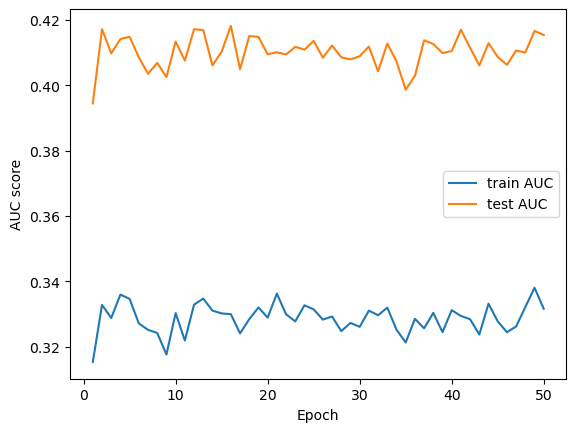

In [32]:
# training and testing
best_auc = 0
best_acc = 0
best_epoch = 0
patience = NUM_EPOCHS
stop_counter = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        # Convert one-hot encoded targets to class labels
        targets = targets.argmax(dim=1)

        targets = targets.squeeze().long()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)
    
    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_model_chestmnist.pth')
        stop_counter = 0
    else:
        stop_counter += 1

    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

    # Check for early stopping
    if stop_counter >= patience:
        print("Early stopping triggered")
        break

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()
